In [1]:
import pydicom
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from scipy import ndimage
from skimage import morphology

## Utility functions

In [2]:
def transform_to_hu(medical_image, image):
    intercept = medical_image.RescaleIntercept
    slope = medical_image.RescaleSlope
    hu_image = image * slope + intercept

    return hu_image

In [5]:
def window_image(image, window_center, window_width):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max
    
    return window_image

In [3]:
def load_and_plot_image(file_path, save=False):
    medical_image = pydicom.read_file(file_path)
    image = medical_image.pixel_array
    
    print(image.shape)
    
    hu_image = transform_to_hu(medical_image, image)
    brain_image = window_image(hu_image, 40, 80)
    bone_image = window_image(hu_image, 400, 1000)
    
    plt.figure(figsize=(20, 10))
    plt.style.use('grayscale')

    plt.subplot(151)
    plt.imshow(image)
    plt.title('Original')
    plt.axis('off')

    plt.subplot(152)
    plt.imshow(hu_image)
    plt.title('Hu image')
    plt.axis('off')

    plt.subplot(153)
    plt.imshow(brain_image)
    plt.title('brain image')
    plt.axis('off')

    plt.subplot(154)
    plt.imshow(bone_image)
    plt.title('bone image')
    plt.axis('off')
    
    if save:
        mpimg.imsave(os.path.join(output_path, f'{file_path[:-4]}-original.png'), image)
        mpimg.imsave(os.path.join(output_path, f'{file_path[:-4]}-hu_image.png'), hu_image)
        mpimg.imsave(os.path.join(output_path, f'{file_path[:-4]}-brain_image.png'), brain_image)
        mpimg.imsave(os.path.join(output_path, f'{file_path[:-4]}-bone_image.png'), bone_image)


## Loading Dicom

In [92]:
medical_image = pydicom.read_file('./Raja/2.dcm')
image = medical_image.pixel_array
print(image.min(), image.max())

hu_image = transform_to_hu(medical_image, image)
print(hu_image.min(), hu_image.max())

-2000 3181
-3024.0 2157.0


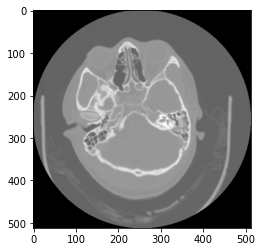

In [108]:
plt.imshow(image, cmap='gray')

In [109]:
image

array([[-2000, -2000, -2000, ..., -2000, -2000, -2000],
       [-2000, -2000, -2000, ..., -2000, -2000, -2000],
       [-2000, -2000, -2000, ..., -2000, -2000, -2000],
       ...,
       [-2000, -2000, -2000, ..., -2000, -2000, -2000],
       [-2000, -2000, -2000, ..., -2000, -2000, -2000],
       [-2000, -2000, -2000, ..., -2000, -2000, -2000]], dtype=int16)

## Daesoo's code

In [103]:
def removeBackgroundFromCT(matImg_source):
    intensity_background = min(matImg_source.reshape(-1))
    intensity_min = min(matImg_source[matImg_source>intensity_background].reshape(-1))
    
    matImage_removedBg= matImg_source.copy()
    matImage_removedBg[matImage_removedBg<intensity_min] = intensity_min
    return matImage_removedBg

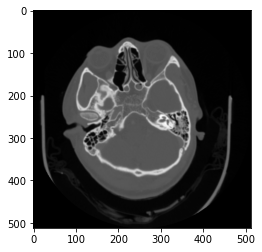

In [104]:
Image_removedBg = removeBackgroundFromCT(image)
plt.imshow(Image_removedBg, cmap='gray')

In [116]:
(min(image.reshape(-1)), max(image.reshape(-1)))

(-2000, 3181)

In [117]:
(min(Image_removedBg.reshape(-1)), max(Image_removedBg.reshape(-1)))

(0, 3181)

In [86]:
## same as below
# nBit_result = 15
# Image_removedBg_scaled = cv2.normalize(Image_removedBg, None, 0, 2**nBit_result-1, cv2.NORM_MINMAX) 

In [105]:
Image_removedBg_scaled = Image_removedBg.astype('uint16')
Image_removedBg_scaled = Image_removedBg.astype('int32')
nBit_result = 16
Image_removedBg_scaled = cv2.normalize(Image_removedBg_scaled, None, 0, 2**nBit_result-1, cv2.NORM_MINMAX) 

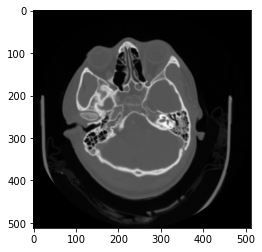

In [118]:
plt.imshow(Image_removedBg_scaled, cmap='gray')

In [119]:
(min(Image_removedBg_scaled.reshape(-1)), max(Image_removedBg_scaled.reshape(-1)))

(0, 65535)

In [120]:
itst_threshold, Image_threshold = cv2.threshold(Image_removedBg_scaled, 0, 2**nBit_result-1, cv2.THRESH_OTSU)
#tst_threshold, Image_threshold = cv2.threshold(Image_removedBg_scaled, 0, 2**nBit_result-1, cv2.BINARY)

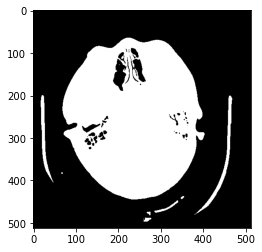

In [122]:
plt.imshow(Image_threshold, cmap='gray')

In [90]:
def getMaskOfLargestContour_bitXto16(src_img):
    value_filled = 65535

    src_img_8bit = src_img.astype(np.uint8)
    contours, _ = cv2.findContours(src_img_8bit, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    res_mask_16bit = np.zeros(src_img_8bit.shape[:2], np.uint16)
    if len(contours) > 0:
        nArea_contours_max = -1
        for pts in contours:
            if cv2.contourArea(pts) > nArea_contours_max:
                contours_max = pts
                nArea_contours_max = cv2.contourArea(pts)
        res_mask_16bit = cv2.fillPoly(res_mask_16bit, [contours_max], value_filled)

    return res_mask_16bit

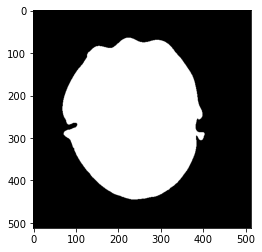

In [107]:
Image_ROI = getMaskOfLargestContour_bitXto16(Image_threshold)
plt.imshow(Image_ROI, cmap='gray')

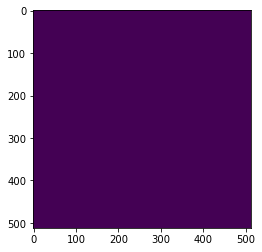

In [126]:
test = np.zeros(image.shape)
plt.imshow(test)

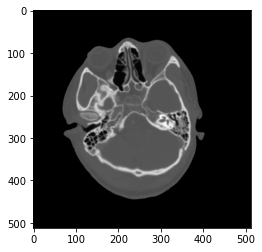

In [128]:
test = image.copy()
test[Image_ROI==0] = 0
plt.imshow(test, cmap='gray')

TypeError: Invalid shape (94653,) for image data

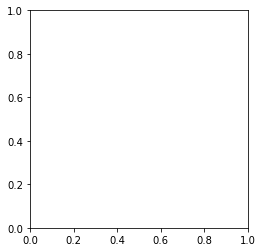

In [124]:
test = np.zeros(image.shape)


plt.imshow(image[Image_ROI>0])

In [94]:
nRange_HU = [-2000, 3818]

In [95]:
result_img = convertImageCheckFromCT(hu_image, nRange_HU, 0)

In [96]:
min(hu_image.reshape(-1)), max(hu_image.reshape(-1))

(-3024.0, 2157.0)

In [97]:
min(result_img.reshape(-1)), max(result_img.reshape(-1))

(0, 182)

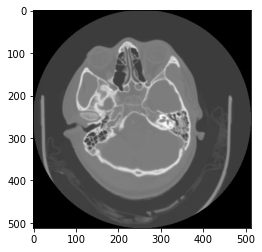

In [98]:
plt.imshow(result_img, cmap='gray')

In [99]:
itst_threshold, result_threshold = cv2.threshold(result_img, 0, 255, cv2.THRESH_OTSU)

In [100]:
itst_threshold

62.0

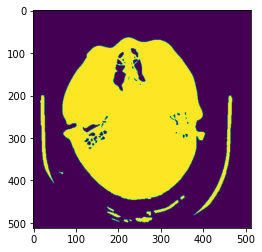

In [101]:
plt.imshow(result_threshold)

In [102]:
load_and_plot_image("2.dcm")

FileNotFoundError: [Errno 2] No such file or directory: '2.dcm'

In [ ]:
# medical_image = pydicom.read_file("1.dcm")
# image = medical_image.pixel_array
# hu_image = transform_to_hu(medical_image, image)
# bone_image = window_image(hu_image, 800, 1000)
# print(bone_image.dtype)

In [ ]:
# def skull_seg(file_path):
#     medical_image = pydicom.read_file(file_path)
#     image = medical_image.pixel_array
    
#     hu_image = transform_to_hu(medical_image, image)
#     bone_image = window_image(hu_image, 800, 1000)
    
#     return bone_image

In [ ]:
def remove_noise(file_path):
    medical_image = pydicom.read_file(file_path)
    image = medical_image.pixel_array
    
    hu_image = transform_to_hu(medical_image, image)
    bone_image = window_image(hu_image, 400, 1000)
    
    kernel = np.ones((5, 5), np.float64)
    img = cv2.erode(bone_image, kernel)
    
    return img

In [ ]:
final_image = remove_noise("1.dcm")
plt.imshow(final_image)

In [ ]:
blurred = cv2.GaussianBlur(final_image, (31, 31), 0) # selected with trail and error for outlier

In [ ]:
# def crop_image(image, display=False):
#     # Create a mask with the background pixels
#     mask = image == 0

#     # Find the brain area
#     coords = np.array(np.nonzero(~mask))
#     top_left = np.min(coords, axis=1)
#     bottom_right = np.max(coords, axis=1)
    
#     # Remove the background
#     croped_image = image[top_left[0]:bottom_right[0],
#                 top_left[1]:bottom_right[1]]
    
#     return croped_image

def add_pad(image, new_height=512, new_width=512):
    height, width = image.shape

    final_image = np.zeros((new_height, new_width))

    pad_left = int((new_width - width) / 2)
    pad_top = int((new_height - height) / 2)
    
    # Replace the pixels with the image's pixels
    final_image[pad_top:pad_top + height, pad_left:pad_left + width] = image
    
    return final_image

In [ ]:
#final_image = crop_image(blurred)
final_image = add_pad(blurred)
plt.imshow(final_image)

In [ ]:
print(final_image.min(), final_image.max())

In [ ]:
# img_uint = blurred.astype('uint8')

In [ ]:
# print(img_uint.min(), img_uint.max())

In [ ]:
thresh, img = cv2.threshold(blurred, 100, 1000, cv2.THRESH_BINARY) #cv2.THRESH_BINARY | cv2.THRESH_OTSU)
plt.imshow(img)